In [2]:
import gym
import d4rl
import math
import pickle
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from tqdm import tqdm
import math
import functools
from types import SimpleNamespace
import torch
import scipy.io
import os
import json
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as torch_dist
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader
import wandb

from models.mlp_ensemble import EnsembleDynamics
from train.runner_fns import train_model, train_diffusion_model
from dataset.utils import parse_stacked_trajectories, collate_fn, create_dataset_split, unpack_mlp_dataset, sample_future_states, permutation_test, get_timeseries_data
from dataset.dataset import D4RL_dataset, D4RL_occ_dataset, CustomDiffusionDataset, CustomDataset 

from diffusion_fns.model import ScoreNet, DiamondModel, SmallScoreNetN, SmallScoreNet
from diffusion_fns.schedule import marginal_prob_std
from dataset.utils import compute_mmd, make_fusion_dataset

# set plotting style
strip_size = 12
label_size = 14
mpl.rcParams["axes.labelsize"] = label_size
mpl.rcParams["xtick.labelsize"] = strip_size
mpl.rcParams["ytick.labelsize"] = strip_size
mpl.rcParams["legend.title_fontsize"] = strip_size
mpl.rcParams["axes.titlesize"] = label_size
mpl.rcParams["figure.titlesize"] = label_size 
data_path = "/home/scratch/avenugo2/FusionControl/data/preprocessed/noshape_ech"
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
env_name = 'fusion'
expid = 'fusion0_silu_1e-05_3_diamond'
with open('./models_rl/'+env_name+'/'+expid+'/commandline_args.txt', 'r') as f:
    args = json.load(f, object_hook=lambda d: SimpleNamespace(**d))

args.order = 2
args.num_steps_denoising = 1000
env_name = 'fusion'
model_name = "diffusion"
hopper_obs_names = [
    "top-z", "top-angle", "thigh-angle", "leg-angle",
    "foot-angle", "top-x-v", "top-z-v", "top-angle-v",
    "thigh-angle-v", "leg-angle-v", "foot-angle-v"
]
max_ep_len = 500
np.random.seed(args.seed)
torch.manual_seed(args.seed)

state_dim = args.obs_dim
action_dim = args.act_dim
'''
if args.time:
    state_dim = args.obs_dim 
else:
    state_dim = args.obs_dim - 1
'''
print("state dim, act dim", state_dim, args.obs_dim, action_dim, args.act_dim)
args.s_churn = 0
marginal_prob_std_fn = functools.partial(marginal_prob_std, device=args.device)
args.marginal_prob_std_fn = marginal_prob_std_fn

model_path = '/zfsauton2/home/avenugo2/CEP-energy-guided-diffusion/Offline_RL_2D/dynamics_pred/models_rl/'+env_name+'/'+expid+'/behavior_ckpt200.pth'
if args.diamond:
    model = DiamondModel(args, state_dim, state_dim).to(args.device)
else:
    print("here")
    #model= SmallScoreNetN(input_dim=state_dim+action_dim, output_dim=state_dim, marginal_prob_std=marginal_prob_std_fn, args=args).to(args.device)
    model = ScoreNet(input_dim=state_dim+action_dim, output_dim=state_dim, marginal_prob_std=marginal_prob_std_fn, args=args).to(args.device)
model.load_state_dict(torch.load(model_path, weights_only=True))
model.eval()
print("Model Loaded.")

state dim, act dim 37 37 22 22
batch norm: False
activation fn: silu
Model Loaded.


SOME DATASET ANALYSIS

In [5]:
with open(f'{data_path}/info.pkl', 'rb') as f:
    info = pickle.load(f)
print("State variables:", info['state_space'])
print("####################")
print("Actions:", info['actuator_space'])

dataset = make_fusion_dataset(args, data_path)

State variables: ['betan_EFIT01', 'dssdenest', 'li_EFIT01', 'q0_EFIT01', 'q95_EFIT01', 'vloop', 'wmhd_EFIT01', 'temp_component1', 'temp_component2', 'temp_component3', 'temp_component4', 'itemp_component1', 'itemp_component2', 'itemp_component3', 'itemp_component4', 'dens_component1', 'dens_component2', 'dens_component3', 'dens_component4', 'rotation_component1', 'rotation_component2', 'rotation_component3', 'rotation_component4', 'pres_EFIT01_component1', 'pres_EFIT01_component2', 'q_EFIT01_component1', 'q_EFIT01_component2']
####################
Actions: ['pinj', 'tinj', 'ipsiptargt', 'dstdenp', 'bt_magnitude', 'bt_is_positive', 'D_tot', 'aminor_EFIT01', 'tritop_EFIT01', 'tribot_EFIT01', 'kappa_EFIT01', 'rmaxis_EFIT01', 'zmaxis_EFIT01', 'ech_pwr_total']
dict_keys(['actuators', 'next_actuators', 'next_states', 'shotnum', 'states', 'time'])
Fusion dataset created.
observations (2875921, 27)
actions (2875921, 14)
terminals (2875921,)
rewards None
sidx (2875921,)
time (2875921,)


In [4]:
obs, act, rwd, next_obs, next_act, terminated, timeout = unpack_mlp_dataset(args, dataset, env_name, num_prev_states = 1, max_ep_len = 100, use_velocity = args.velocity)

next_terminal = np.zeros(obs.shape[0])
future_t = obs.shape[0] - 1
for i in range(obs.shape[0] - 1, -1, -1):
  if terminated[i]:
    future_t = i
  next_terminal[i] = future_t
next_terminal = np.array(next_terminal)
if args.occupancy:
    future_obs = sample_future_states(next_terminal, np.arange(obs.shape[0]), args.gamma, next_obs, max_horizon = 200)
else:
    future_obs = next_obs
    
# reshape dataset into episodes with padding
pad_dataset = parse_stacked_trajectories(
    torch.from_numpy(obs), 
    torch.from_numpy(act), 
    torch.from_numpy(rwd), 
    torch.from_numpy(next_obs),
    torch.from_numpy(future_obs),
    torch.from_numpy(terminated), 
    torch.from_numpy(next_terminal),
    torch.from_numpy(timeout) if timeout is not None else None, 
    torch.from_numpy(next_act) if next_act is not None else None,
    max_eps=500
)
args.obs_dim = obs.shape[-1]
args.act_dim = act.shape[-1]

    
pad_dataset, mask = collate_fn(pad_dataset, pad_value=torch.nan)
print("data size:", {k: v.shape if v is not None else None for k, v in pad_dataset.items()})
print("mask shape:", mask.shape)
print("min eps len:", mask.sum(0).min(), "max eps len:", mask.sum(0).max())

Velocity: False
data size: (1020598, 37) (1020598, 22) (1020598, 1) (1020598, 37) (1020598, 22) (1020598,)
num terminated: 7843
num timeout: 10205
num terminated and timeout: 75
data size: {'obs': torch.Size([100, 500, 37]), 'act': torch.Size([100, 500, 22]), 'rwd': torch.Size([100, 500, 1]), 'next_obs': torch.Size([100, 500, 37]), 'future_obs': torch.Size([100, 500, 37]), 'next_act': torch.Size([100, 500, 22]), 'done': torch.Size([100, 500]), 'next_done': torch.Size([100, 500])}
mask shape: torch.Size([100, 500])
min eps len: tensor(1.) max eps len: tensor(100.)


SOME RANDOM ANALYSIS


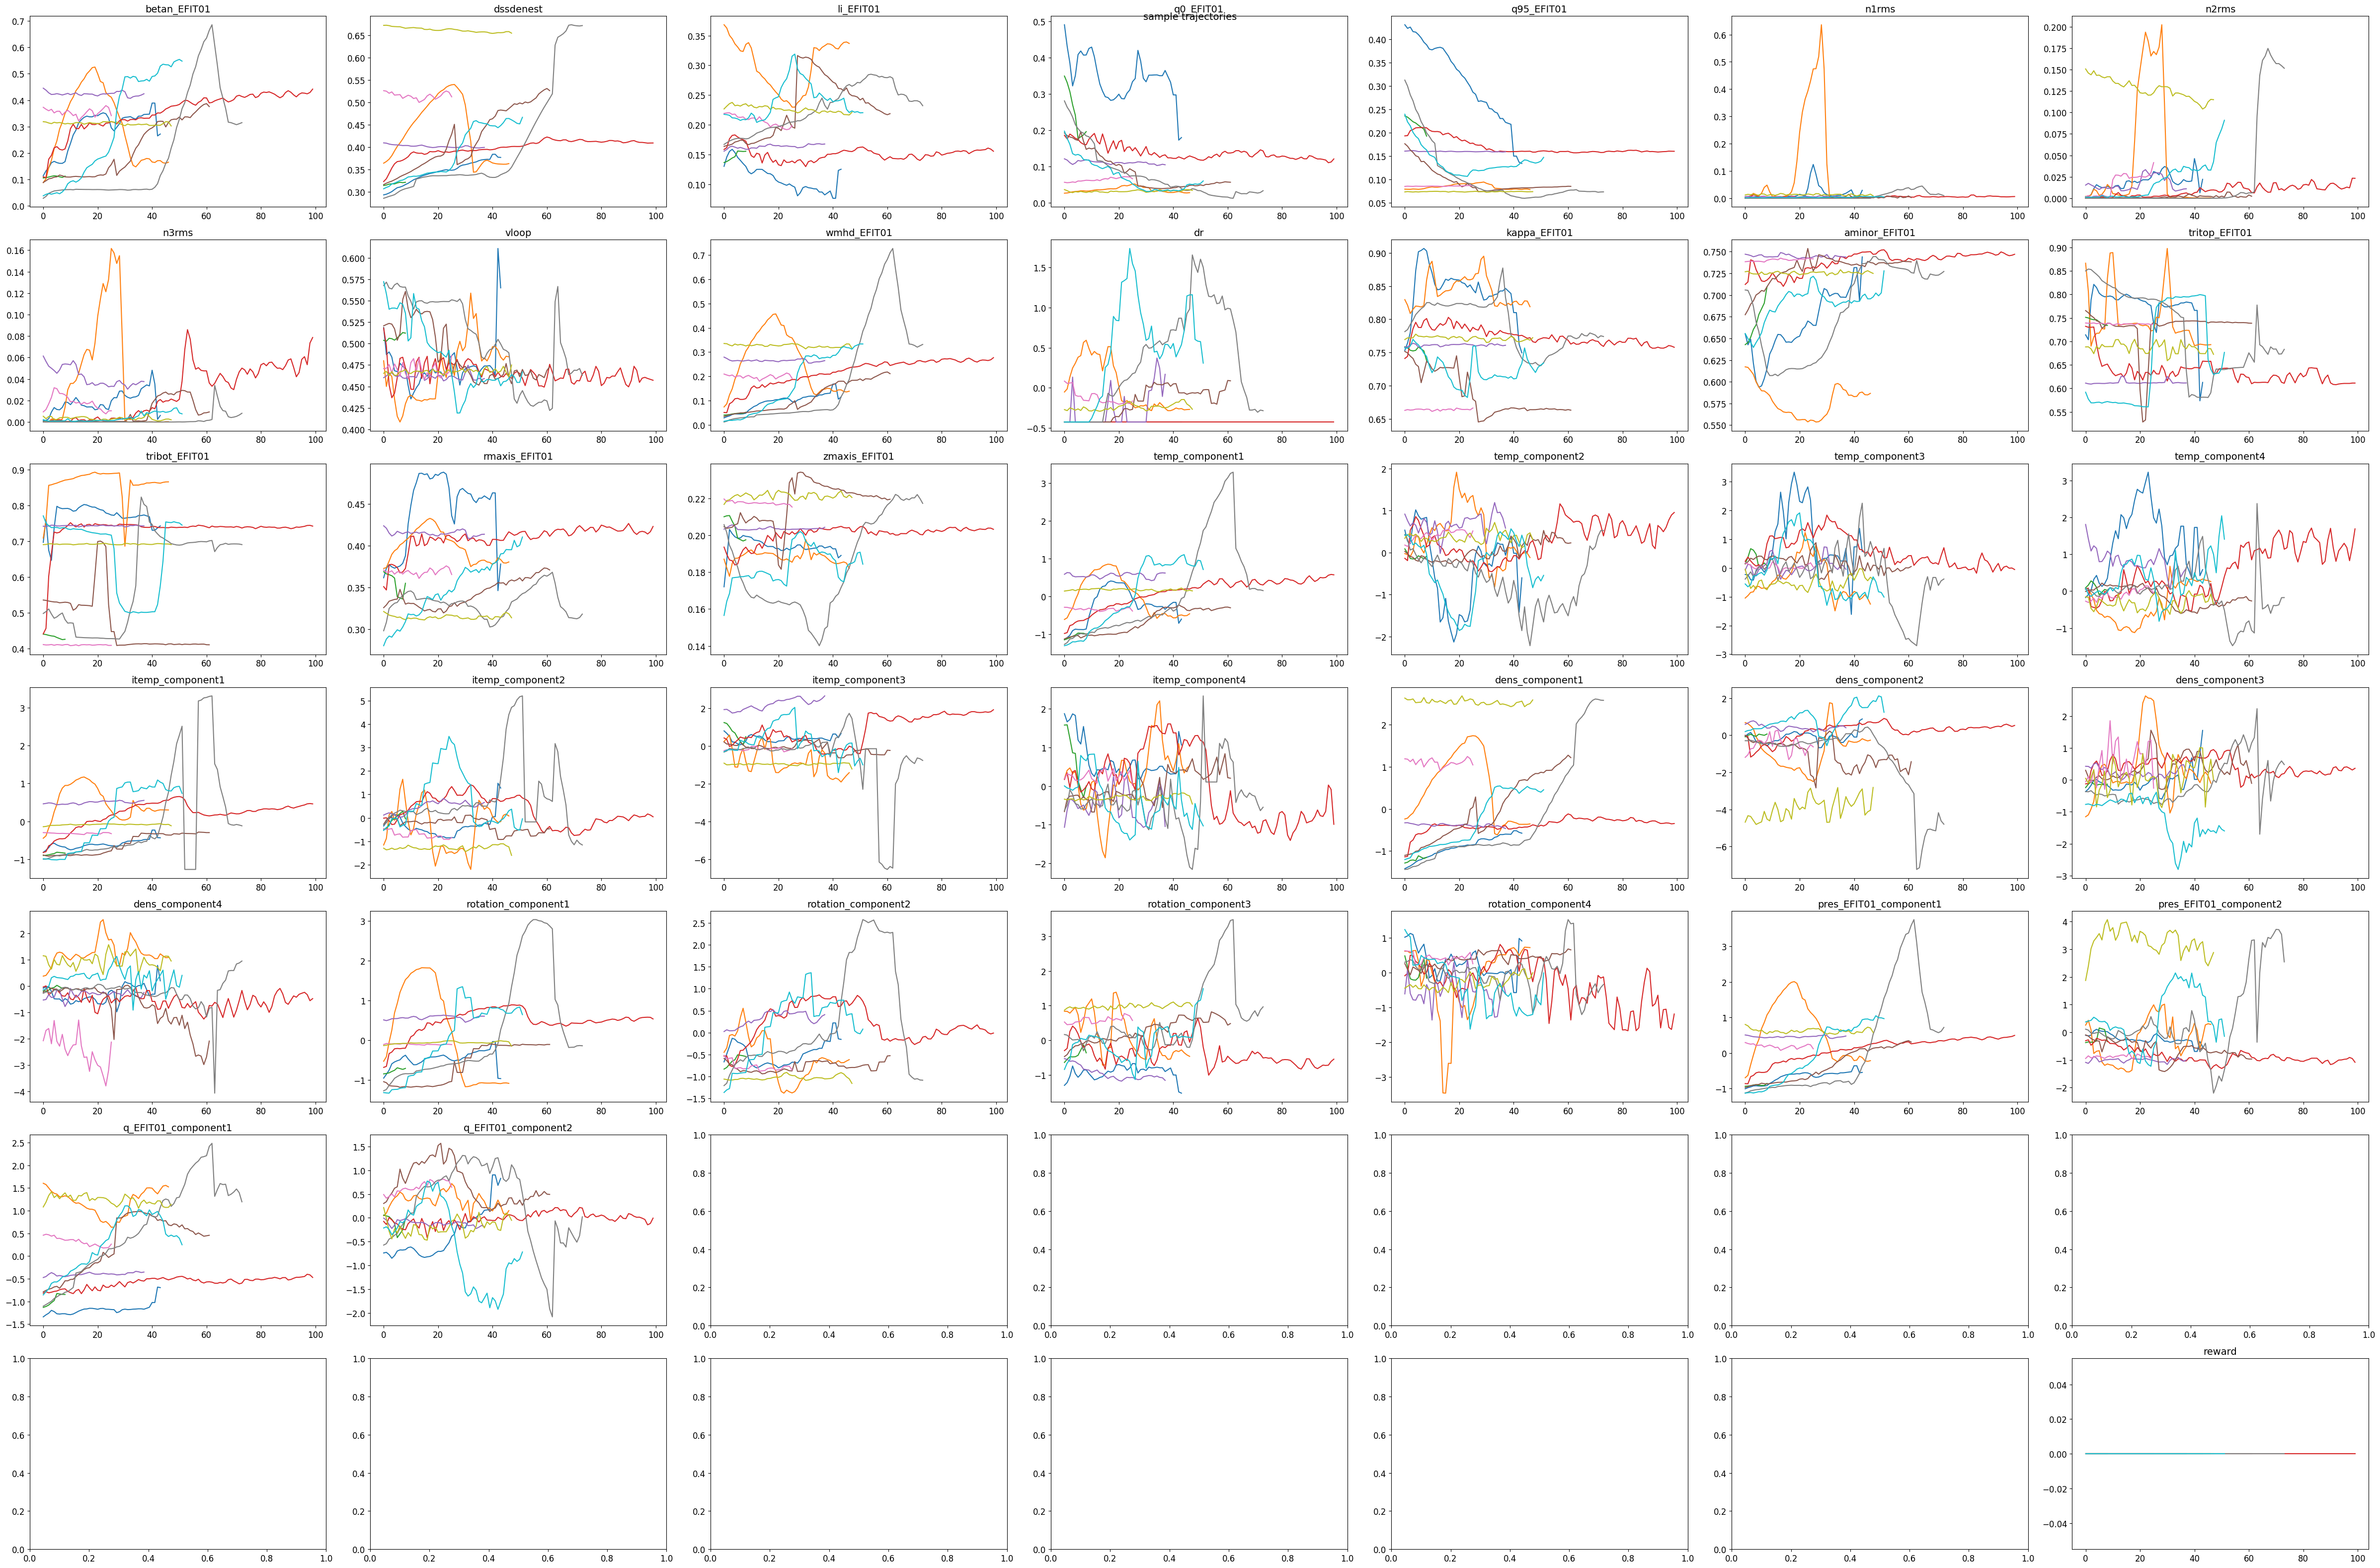

In [5]:
# plot a batch of trajectories
batch_size = 10
idx = np.arange(mask.shape[1])
np.random.permutation(idx)
idx = idx[:batch_size]
grid_side = int(np.sqrt(pad_dataset['obs'].shape[-1])) + 1

fig, ax = plt.subplots(grid_side, grid_side, figsize=(48, 32))
ax = ax.flat
for i in range(obs.shape[1]):
    ax[i].plot(pad_dataset["obs"][:, idx, i])
    ax[i].set_title(info['state_space'][i])

ax[-1].plot(pad_dataset["rwd"][:, idx].squeeze(-1))
ax[-1].set_title("reward")
plt.suptitle("sample trajectories")
plt.tight_layout()
plt.show()

In [6]:
# subsample data
num_samples = obs.shape[0]#200000
print("num_samples", num_samples)
train_ratio = 0.8
print(info['state_space'])
print(info['actuator_space'])
args.memory = False
if args.memory:
    obs, act, rwd, next_obs, next_act, terminated, timeout = get_timeseries_data(obs, act, rwd, next_obs, next_act, terminated, timeout, seq_length = 10)


print(obs.shape)
train_data, test_data = create_dataset_split(num_samples, train_ratio, obs, act, next_obs, future_obs, next_act, rwd, terminated, next_terminal, normalize = args.normalize, memory = args.memory)
obs_train_norm, act_train, next_obs_train_norm, future_obs_train_norm, rwd_train_norm, next_act_train, terminated_train, next_terminal_train, idx_train, obs_mean, obs_std, rwd_mean, rwd_std = train_data
obs_test_norm, act_test, next_obs_test_norm, future_obs_test_norm, rwd_test_norm, next_act_test, terminated_test, next_terminal_test, idx_test =  test_data

num_samples 1020598
['betan_EFIT01', 'dssdenest', 'li_EFIT01', 'q0_EFIT01', 'q95_EFIT01', 'n1rms', 'n2rms', 'n3rms', 'vloop', 'wmhd_EFIT01', 'dr', 'kappa_EFIT01', 'aminor_EFIT01', 'tritop_EFIT01', 'tribot_EFIT01', 'rmaxis_EFIT01', 'zmaxis_EFIT01', 'temp_component1', 'temp_component2', 'temp_component3', 'temp_component4', 'itemp_component1', 'itemp_component2', 'itemp_component3', 'itemp_component4', 'dens_component1', 'dens_component2', 'dens_component3', 'dens_component4', 'rotation_component1', 'rotation_component2', 'rotation_component3', 'rotation_component4', 'pres_EFIT01_component1', 'pres_EFIT01_component2', 'q_EFIT01_component1', 'q_EFIT01_component2']
['pinj', 'tinj', 'ipsiptargt', 'dstdenp', 'bt_magnitude', 'bt_is_positive', 'gasA', 'gasB', 'gasC', 'gasD', 'IDTDRSEP', 'IDTGAPIN', 'IDTRP', 'IDTRXBOT', 'IDTRXTOP', 'IDTSBOTIN', 'IDTSBOTOUT', 'IDTSTOPIN', 'IDTSTOPOUT', 'IDTZP', 'IDTZXBOT', 'IDTZXTOP']
(1020598, 37)
idx length 1020598
torch.Size([37])
data size: (1020598, 37) (10

[ 2.1455028e+00  5.8766403e+00  2.9362805e+00  1.4822938e+00
  1.9435333e+00  4.7749594e-01  6.2074882e-01  6.4628768e-01
  1.5940739e+01  1.7387705e+00  2.3733105e-01  1.3016823e+01
  1.2164261e+01  6.3204541e+00  4.5789032e+00  9.0858727e+00
  9.0067911e+00  9.0393387e-02 -2.6944384e-02  6.0900081e-02
  1.1012127e-01  1.7113091e-01  1.0672658e-03 -8.9811431e-03
 -2.0856457e-02 -3.6761101e-02  3.0098425e-02  1.9592918e-02
 -7.4523650e-02 -1.7365860e-02  4.8087921e-02  7.9355352e-02
 -3.5897288e-02  9.3206830e-02 -4.9803004e-02  6.2212542e-02
 -5.8787297e-03]


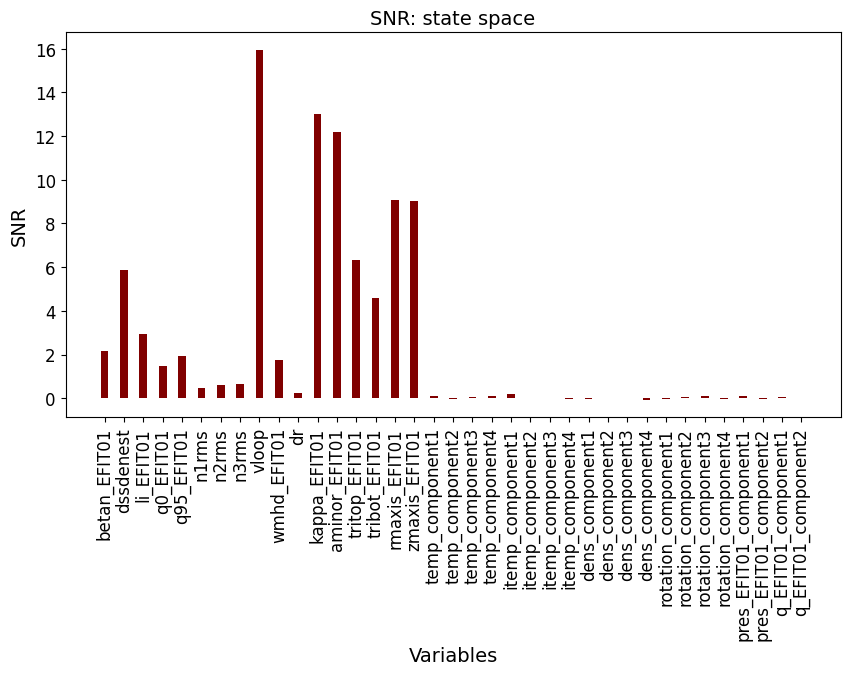

[ 2.043258    3.1447976   3.732318    2.3213844  -0.08764461  0.88662344
  3.3199086   7.4667706   0.8973283  11.090215    4.612225    4.7748003
  8.943749    8.922545    9.296602    1.9779333  22.82858     2.013359
 22.16112     9.2236805   1.6264652   9.643951  ]


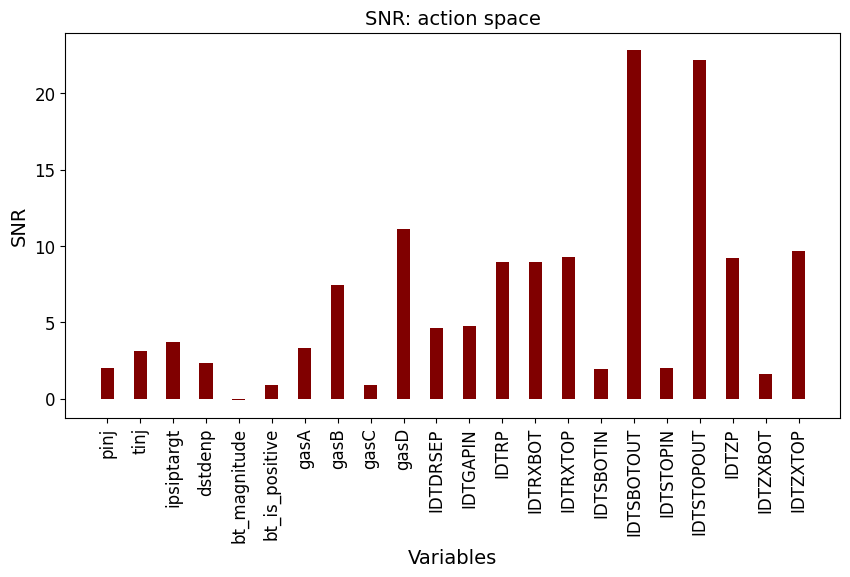

In [7]:
def signaltonoise(a, axis=0, ddof=0):
    a = np.asanyarray(a)
    m = a.mean(axis)
    sd = a.std(axis=axis, ddof=ddof)
    return np.where(sd == 0, 0, m/sd)

snr = signaltonoise(obs_train_norm)
print(snr)

fig = plt.figure(figsize = (10, 5))

# creating the bar plot
plt.bar(info['state_space'], snr, color ='maroon', 
        width = 0.4)
plt.xticks(rotation=90)
plt.xlabel("Variables")
plt.ylabel("SNR")
plt.title("SNR: state space")
plt.show()

snr = signaltonoise(act_train)
print(snr)

fig = plt.figure(figsize = (10, 5))

# creating the bar plot
plt.bar(info['actuator_space'], snr, color ='maroon', 
        width = 0.4)
plt.xticks(rotation=90)
plt.xlabel("Variables")
plt.ylabel("SNR")
plt.title("SNR: action space")
plt.show()

CREATE DATASET AND DATALOADERS, TRAIN MODEL

In [8]:
#wandb.login()
#run = wandb.init(project="ob")

train_set = CustomDiffusionDataset(obs_train_norm, act_train, next_obs_train_norm, future_obs_train_norm, next_act_train, rwd_train_norm, terminated_train, next_terminal_train, idx_train, device = args.device)
test_set =  CustomDiffusionDataset(obs_test_norm, act_test, next_obs_test_norm, future_obs_test_norm, next_act_test, rwd_test_norm, terminated_test, next_terminal_test, idx_test, device = args.device)

batch_size = 256
train_loader = DataLoader(train_set, batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size, shuffle=False)
#print("Using Diamond Model:", args.diamond)
#model = train_diffusion_model(args, dataset = train_set, data_loader = train_loader)

LOAD DIFFUSION MODEL FROM CHECKPOINT

ONE STEP PREDICTION

In [9]:
def predict_one_step_mlp(obs, act, model, model_name = "mlp", sample_mean=False):
    with torch.no_grad():
        next_obs_pred, rwd_pred = model.sample_transition_dist(
            obs, act, sample_mean=sample_mean
        )
        return next_obs_pred, rwd_pred

def plot_prediction(pred, target, ax, titles):
    for i in range(pred.shape[-1]):
        ax[i].plot(target[:, i], pred[:, i], ".")
        ax[i].plot(target[:, i], target[:, i], "-", alpha=0.7)
        ax[i].set_title(titles[i])

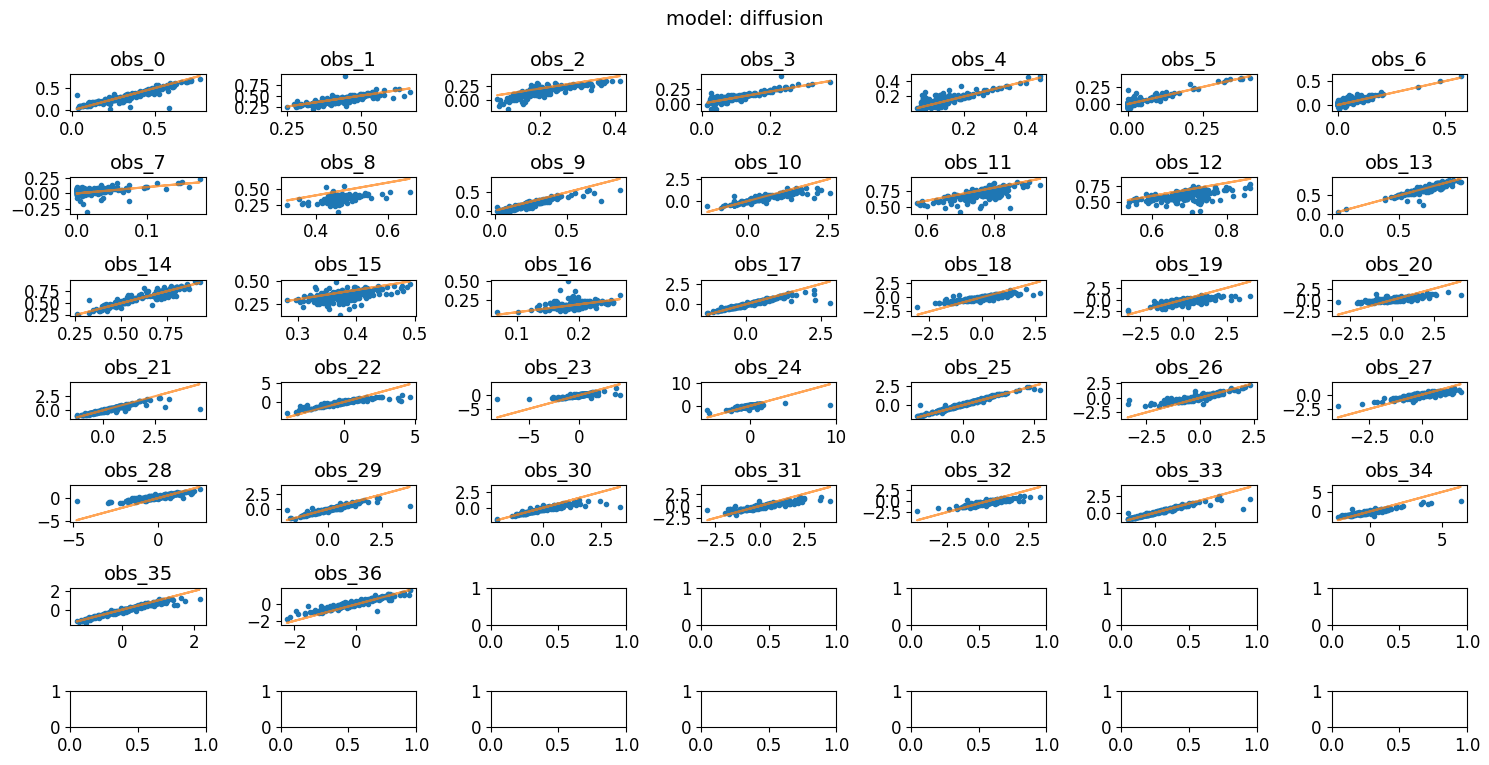

In [10]:
data = next(iter(test_loader))
data = {k: d.to(args.device) for k, d in data.items()}
s = data['s']
a = data['a']
s_ = data['s_']
if args.diamond:
    pred, _ = model.sample_occ(s, a)
    pred = pred.detach().cpu().numpy() 
else:
    condition = torch.cat([s, a], dim = -1)
    pred = model.sample_occ(condition, None).detach().cpu().numpy() 
target = s_.cpu().numpy()
model.condition = None

grid_side = int(np.sqrt(obs.shape[-1])) + 1
fig, ax = plt.subplots(grid_side, grid_side, figsize=(15, 8))
obs_names = ["obs_"+ str(i) for i in range(obs[0].shape[-1])]
plot_prediction(pred, target, ax.flat, obs_names + ["reward"])
plt.suptitle(f"model: {model_name}")
plt.tight_layout(rect=[0, 0.03, 1, 0.99])
plt.show()


SIMULATE TRAJECTORIES

In [11]:
def simulate(args, obs0, act_seq, model, sample_mean=False):
    """ Simulate forward in batch using dataset actions """
    print("Velocity:", args.velocity)
    obs = obs0.clone().to(args.device) #(10, 29), act seq: T, 10, 8

    obs_seq = [obs] + []  
    rwd_seq = [] 
    for t in range(len(act_seq)):
        with torch.no_grad():

            if args.occupancy:
                if args.diamond:
                    next_obs, _ = model.sample_occ(obs.to(args.device), act_seq[0].to(args.device))
                else:
                    condition = torch.cat([obs.to(args.device), act_seq[0].to(args.device)], dim = -1)
                    next_obs = model.sample_occ(condition, None, diffusion_steps=args.diffusion_steps)
            else:
                if args.diamond:
                    next_obs, _ = model.sample_occ(obs.to(args.device), act_seq[t].to(args.device))
                else:
                    condition = torch.cat([obs.to(args.device), act_seq[t].to(args.device)], dim = -1)
                    next_obs = model.sample_occ(condition, None, diffusion_steps=args.diffusion_steps)
            rwd = None  
            if args.velocity:
                next_obs = obs + next_obs
                
        
        obs_seq.append(next_obs)
        rwd_seq.append(rwd)
        if not args.occupancy:
            obs = next_obs.clone()

    obs_seq = torch.stack(obs_seq)
    rwd_seq = torch.stack(rwd_seq) if rwd_seq[0] is not None else None
    return obs_seq, rwd_seq

def plot_simulation(pred, target, ax, titles):
    for i in range(pred.shape[-1]):
        if args.occupancy:
            ax[i].plot(target[:, i], "x")
            ax[i].plot(pred[:, i], "o", alpha=0.3)
        else:
            ax[i].plot(target[..., i], "r-", linewidth=2)
            ax[i].plot(pred[..., i], "b-", alpha=0.3)
        ax[i].set_title(titles[i])

GENERATING N SAMPLE TRAJECTORIES, STARTING FROM A GIVEN STATE AND GIVEN AN ACTION SEQUENCE

In [17]:
# parse dataset trajectories
max_eps = 10
traj_dataset = parse_stacked_trajectories(obs, act, rwd, next_obs, torch.from_numpy(future_obs), terminated, torch.from_numpy(next_terminal), timeout, next_act, max_eps)
# parse a trajectory
i = 0
obs_true = torch.tensor(traj_dataset[i]["obs"])
act_true = torch.tensor(traj_dataset[i]["act"])
rwd_true = torch.tensor(traj_dataset[i]["rwd"].reshape(-1, 1))

obs_true_norm = (obs_true - obs_mean) / obs_std if args.normalize else obs_true
obs0_norm = obs_true_norm[0].view(1, -1) 
act_seq = act_true
# duplicate
num_samples = 10
obs0_norm = obs0_norm.repeat_interleave(num_samples, dim=0)
act_seq = act_seq.unsqueeze(-2).repeat_interleave(num_samples, dim=-2)

print("obs0_norm", obs0_norm.shape)
print("act_seq", act_seq.shape)

obs0_norm torch.Size([10, 37])
act_seq torch.Size([44, 10, 22])


In [58]:
env_name = 'fusion'
expid = 'fusion0_silu_0.0001_vel_diamond'
with open('./models_rl/'+env_name+'/'+expid+'/commandline_args.txt', 'r') as f:
    args = json.load(f, object_hook=lambda d: SimpleNamespace(**d))
print(args)

args.order = 1
args.num_steps_denoising = 5
args.s_noise = 1.003
args.s_tmin = 0.05
args.s_tmax = 50
args.sigma_max = 80
args.s_churn = 0.3#0.3
env_name = 'fusion'
model_name = "diffusion"
hopper_obs_names = [
    "top-z", "top-angle", "thigh-angle", "leg-angle",
    "foot-angle", "top-x-v", "top-z-v", "top-angle-v",
    "thigh-angle-v", "leg-angle-v", "foot-angle-v"
]
max_ep_len = 500
np.random.seed(args.seed)
torch.manual_seed(args.seed)

state_dim = args.obs_dim
action_dim = args.act_dim
'''
if args.time:
    state_dim = args.obs_dim 
else:
    state_dim = args.obs_dim - 1
'''
print("state dim, act dim", state_dim, args.obs_dim, action_dim, args.act_dim)
marginal_prob_std_fn = functools.partial(marginal_prob_std, device=args.device)
args.marginal_prob_std_fn = marginal_prob_std_fn

model_path = '/zfsauton2/home/avenugo2/CEP-energy-guided-diffusion/Offline_RL_2D/dynamics_pred/models_rl/'+env_name+'/'+expid+'/behavior_ckpt750.pth'
if args.diamond:
    model = DiamondModel(args, state_dim, state_dim).to(args.device)
else:
    print("here")
    #model= SmallScoreNetN(input_dim=state_dim+action_dim, output_dim=state_dim, marginal_prob_std=marginal_prob_std_fn, args=args).to(args.device)
    model = ScoreNet(input_dim=state_dim+action_dim, output_dim=state_dim, marginal_prob_std=marginal_prob_std_fn, args=args).to(args.device)
model.load_state_dict(torch.load(model_path, weights_only=True))
model.eval()
print("Model Loaded.")

namespace(env='fusion', seed=0, expid='fusion0_silu_0.0001_vel_diamond', device='cuda:3', save_model=1, debug=0, alpha=3.0, lr=0.0001, gamma=0.95, train_ratio=0.9, n_epochs=1000, batch_size=256, actor_load_path=None, diffusion_steps=15, M=16, seed_per_evaluation=10, s=None, method='CEP', act='silu', q_alpha=3.0, num_gpus=1, lr_warmup_steps=100, target_update_interval=2, occupancy=False, normalize=False, use_norm=False, use_future_state=False, qlearning_dataset=False, diamond=True, small=False, velocity=True, sep_action=False, use_lr_sched=False, num_steps_denoising=3, num_prev_states=1, cond_channels=256, sigma_min=0.002, sigma_max=5.0, sigma_data=1.0, rho=7, loc=-0.4, scale=1.2, sampling_sigma_min=0.002, sampling_sigma_max=20, order=1, s_tmin=0.0, s_tmax=inf, s_noise=1.0, sigma_offset_noise=0.3, obs_dim=37, act_dim=22)
state dim, act dim 37 37 22 22
batch norm: False
activation fn: silu
Model Loaded.


Occupancy False
Velocity: True
(10, 10, 37) torch.Size([10, 37])
Num dimensions: 37


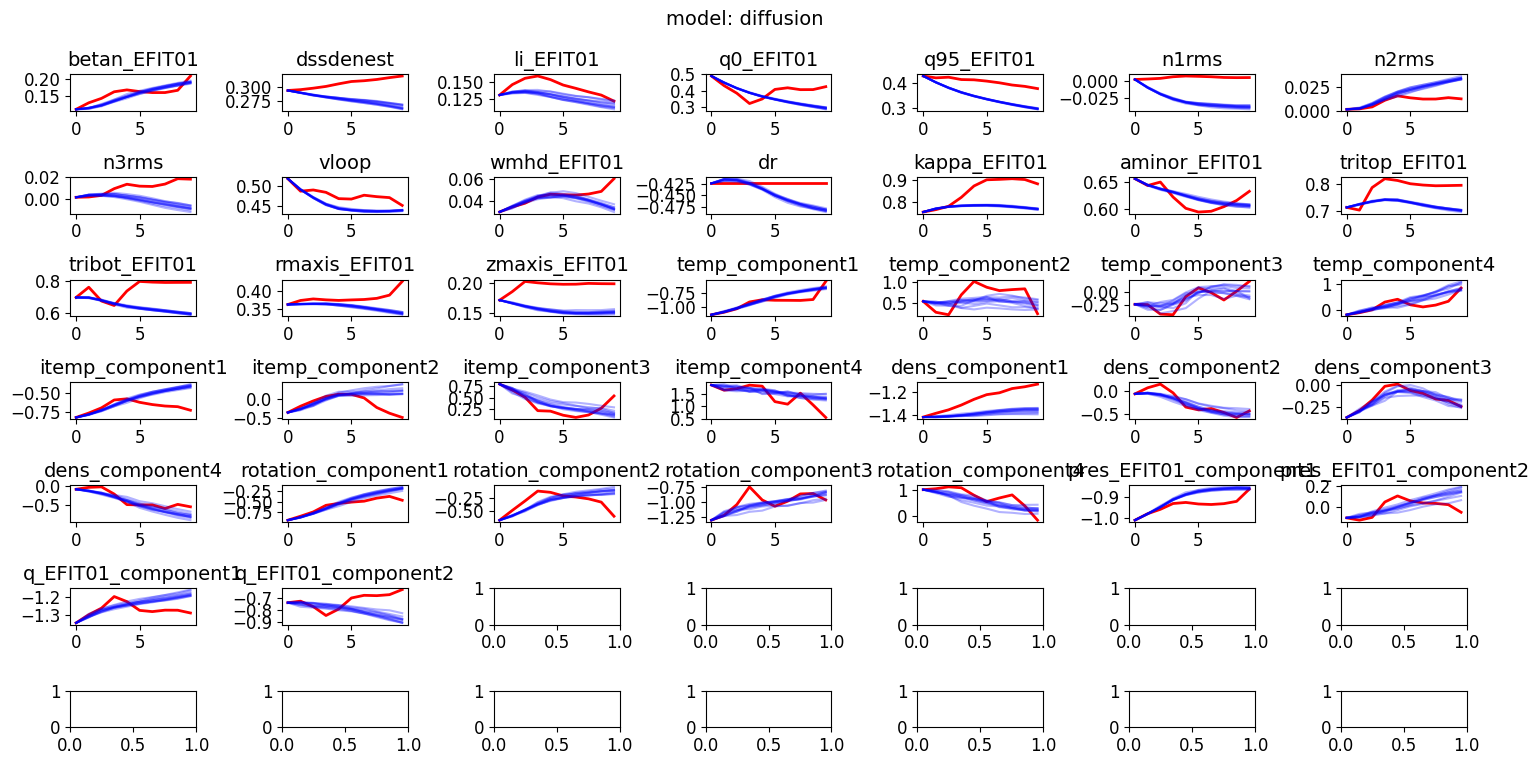

MMD between the two distributions: 0.0098
MSE between pred and target: 0.0195


In [59]:
# simulate relu model
print("Occupancy", args.occupancy)
torch.manual_seed(args.seed)
T = 10

obs_sim, rwd_sim = simulate(args, obs0_norm.to(torch.float32), act_seq[:T].to(torch.float32), model, sample_mean=False)

# denormalize
obs_sim = obs_sim.cpu().numpy() * obs_std.cpu().numpy() + obs_mean.cpu().numpy() if args.normalize else obs_sim.cpu().numpy()
rwd_sim = rwd_sim * rwd_std + rwd_mean if args.normalize and rwd_sim is not None else rwd_sim

#obs_sim = np.clip(obs_sim, a_min=-5, a_max=5)
    
pred = np.concatenate([obs_sim[:-1], rwd_sim], axis=-1) if model_name == "mlp" else obs_sim[:-1]
target = np.concatenate([obs_true, rwd_true], axis=-1)[:T] if model_name == "mlp" else obs_true[:T]

if args.occupancy:
    pred = pred.reshape((pred.shape[0]*pred.shape[1], -1))
print(pred.shape, target.shape)

grid_side = int(np.sqrt(obs.shape[-1])) + 1
fig, ax = plt.subplots(grid_side, grid_side, figsize=(15, 8))
print("Num dimensions:", len(info["state_space"]))
plot_simulation(pred, target, ax.flat, info["state_space"])
plt.suptitle(f"model: {model_name}")
plt.tight_layout(rect=[0, 0.03, 1, 0.99])
plt.show()

#if args.occupancy:
pred_mmd = pred.reshape((pred.shape[0]*pred.shape[1], -1))
target = target.reshape((target.shape[0], -1))

mmd_value = compute_mmd(pred_mmd, target)
mse = np.mean((pred.mean(axis = 1) - target.numpy())**2)
print(f"MMD between the two distributions: {mmd_value:.4f}")
print(f"MSE between pred and target: {mse:.4f}")
